In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import math

plt.rcParams['figure.figsize'] = [16, 4]
from plot_utils import *

In [143]:
def plot_mouli_te_variation_with_pval(ax,run_list,pval_list,main_enum,plot_item_list,fname_pattern,title,label_prefix=""):
    #Getting the result dict
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    result_dict_cad = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_cad.json",
    )
    
    
    #Getting the mouli's tv estimate of the TE
    avg_mouli_tv_pred = get_avg_tv_pred(
            run_list=run_list,
            pval_list=pval_list,
            tv_fname_pattern = fname_pattern+"mouli_pred_tv_data.json"
    )
    
    #Plotting the correlation
    offset_sub=1
    if "nlp_toy3" in fname_pattern:
        offset_sub=0
        correlation_items = ["y-tcausal","y-tconfound","y-tspurious",]
        for corr_item in correlation_items:
            corr_val_mean = np.array([result_dict_erm[pval][corr_item]["mean"] for pval in pval_list])
            corr_val_std = np.array([result_dict_erm[pval][corr_item]["std"] for pval in pval_list])
            ax[0].plot(pval_list,corr_val_mean,ls="-.",marker="o",label=label_prefix+corr_item,alpha=0.7)
            ax[0].fill_between(pval_list,corr_val_mean-corr_val_std,corr_val_mean+corr_val_std,alpha=0.3)
            ax[0].set_xlabel("pval")
            ax[0].set_ylim(0.0,1.0)
            ax[0].set_ylabel("topic correlation")
            ax[0].grid(True)
            ax[0].legend()
            ax[0].set_title(title)
            
    
    #plotting the avg mouli tv
    tv_pval_var_mean = np.array([avg_mouli_tv_pred[pval]["mean"] for pval in pval_list])
    tv_pval_var_std = np.array([avg_mouli_tv_pred[pval]["std"] for pval in pval_list])
    ax[1-offset_sub].plot(pval_list,tv_pval_var_mean,ls="-.",marker="o",alpha=0.7,label=label_prefix)
    ax[1-offset_sub].fill_between(pval_list,tv_pval_var_mean-tv_pval_var_std,tv_pval_var_mean+tv_pval_var_std,alpha=0.3)
    ax[1-offset_sub].set_xlabel("pval")
#     ax[1].set_ylim(0.0,1.0)
    ax[1-offset_sub].set_ylabel("|P(Y|phi(X)) - P(Y|X)|")
    ax[1-offset_sub].grid(True)
    ax[1-offset_sub].set_title(title)
    ax[1-offset_sub].legend()
    
    
    #Plotting the rest the items
    for pidx,plot_item in enumerate(plot_item_list):
        #Plotting the results
        item_yval_erm = np.array([result_dict_erm[pval][plot_item]["mean"] for pval in pval_list])
        yerr_erm = np.array([result_dict_erm[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_erm,label=label_prefix+"erm",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_erm-yerr_erm,item_yval_erm+yerr_erm,alpha=0.3)
        
        #Plotting the results
        item_yval_cad = np.array([result_dict_cad[pval][plot_item]["mean"] for pval in pval_list])
        yerr_cad = np.array([result_dict_cad[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_cad,label=label_prefix+"cad",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_cad-yerr_cad,item_yval_cad+yerr_cad,alpha=0.3)
        
        
        ax[pidx+2-offset_sub].set_xlabel("pval")
        #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
        ax[pidx+2-offset_sub].set_ylabel(plot_item)
        ax[pidx+2-offset_sub].legend()
        ax[pidx+2-offset_sub].grid(True)
        ax[pidx+2-offset_sub].set_title(title)

In [132]:
def read_tv_json_file(tv_fname):
    with open(tv_fname,"r") as rhandle:
        pred_tv_data = json.load(rhandle)
    return pred_tv_data

def get_avg_tv_pred(run_list,pval_list,tv_fname_pattern,item_list):
    avg_tv_pval_dict = defaultdict(dict)
    #Going over the pval
    for pval in pval_list:
        avg_tv_pval_dict[pval]["val_list"]=[]
        #Going over the runs to get the average
        for item_name in item_list:
            for rnum in run_list:
                pred_tv_data = read_tv_json_file(
                                            tv_fname_pattern.format(pval,rnum)
                )
                avg_tv_pval_dict[pval][item_name]["val_list"].append(pred_tv_data[item_name])
            #Getting the avarge over the pval
            avg_tv_pval_dict[pval][item_name]["mean"]=np.mean(avg_tv_pval_dict[pval][item_name]["val_list"])
            avg_tv_pval_dict[pval][item_name]["std"]=np.std(avg_tv_pval_dict[pval][item_name]["val_list"])
    
    return avg_tv_pval_dict

# First Contact

TypeError: plot_mouli_te_variation_with_pval() missing 1 required positional argument: 'title'

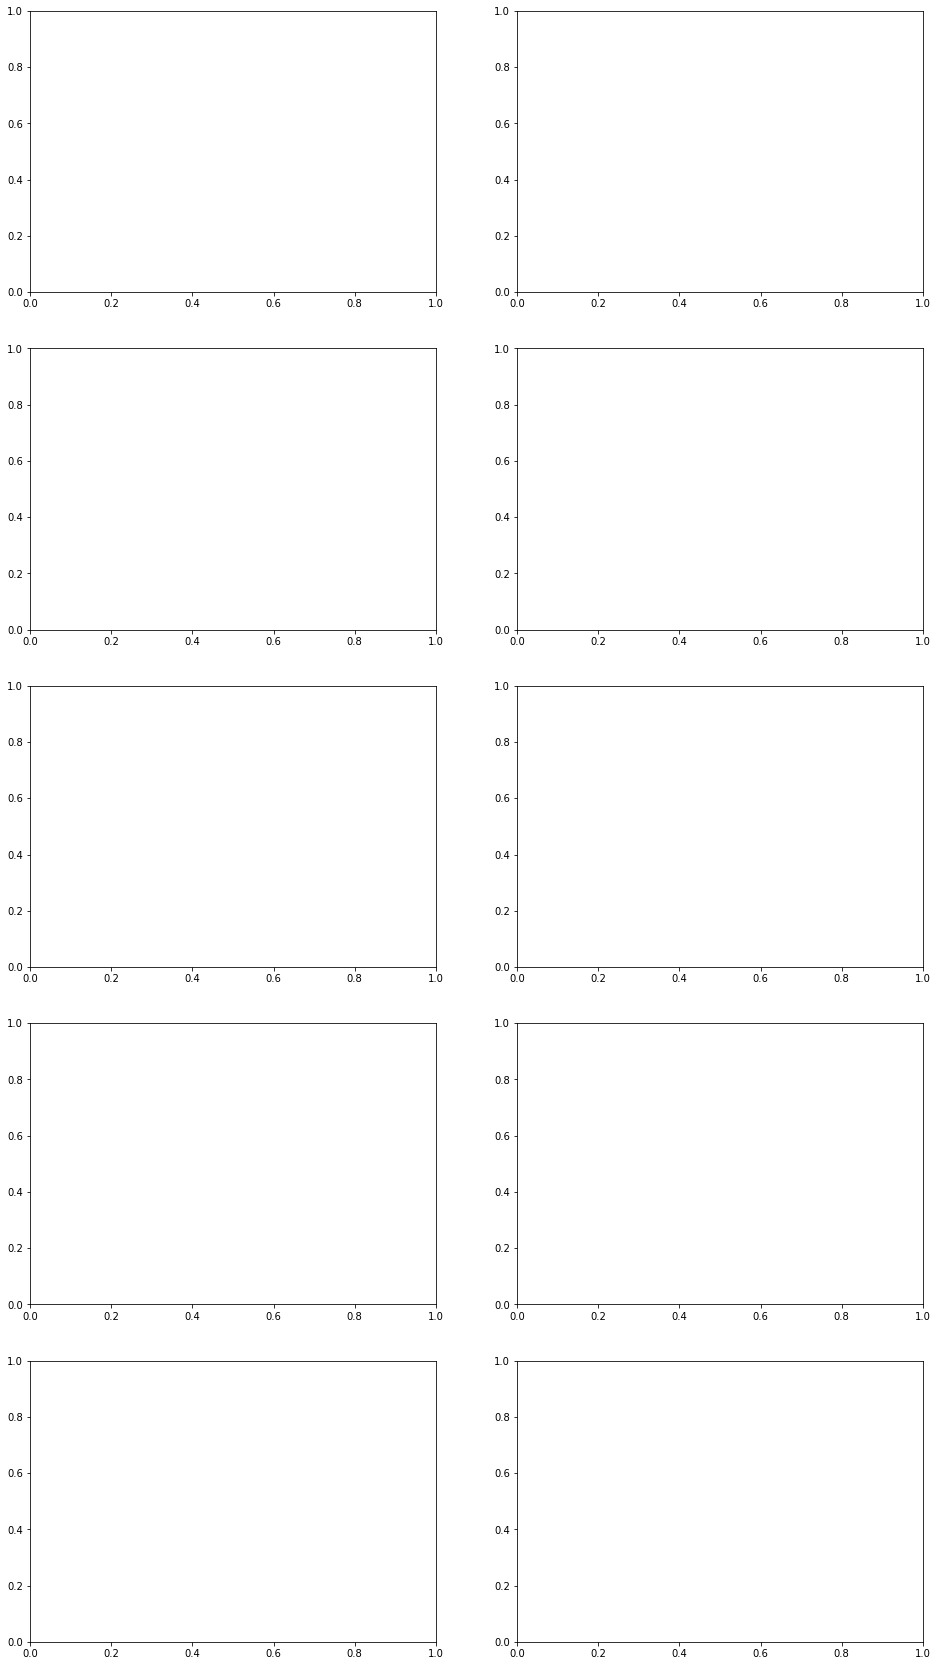

In [141]:
run_list=[1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name ="spurious"
sample=1000
noise=0.0
mvsel_mode_list=["acc","loss"] #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+2,2)


for midx,mvsel_mode in enumerate(mvsel_mode_list):
    plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                      run_list=run_list,
                                      pval_list=pval_list,
                                      main_enum=main_enum,
                                      plot_item_list = plot_item_list,
                                      fname_pattern = fname_pattern.format(
                                                                        "{1}",
                                                                        topic_name,
                                                                        sample,
                                                                        noise,
                                                                        "{0}",
                                                                        mvsel_mode,
                                      ),
    )
plt.show()

# TOY3 dataset

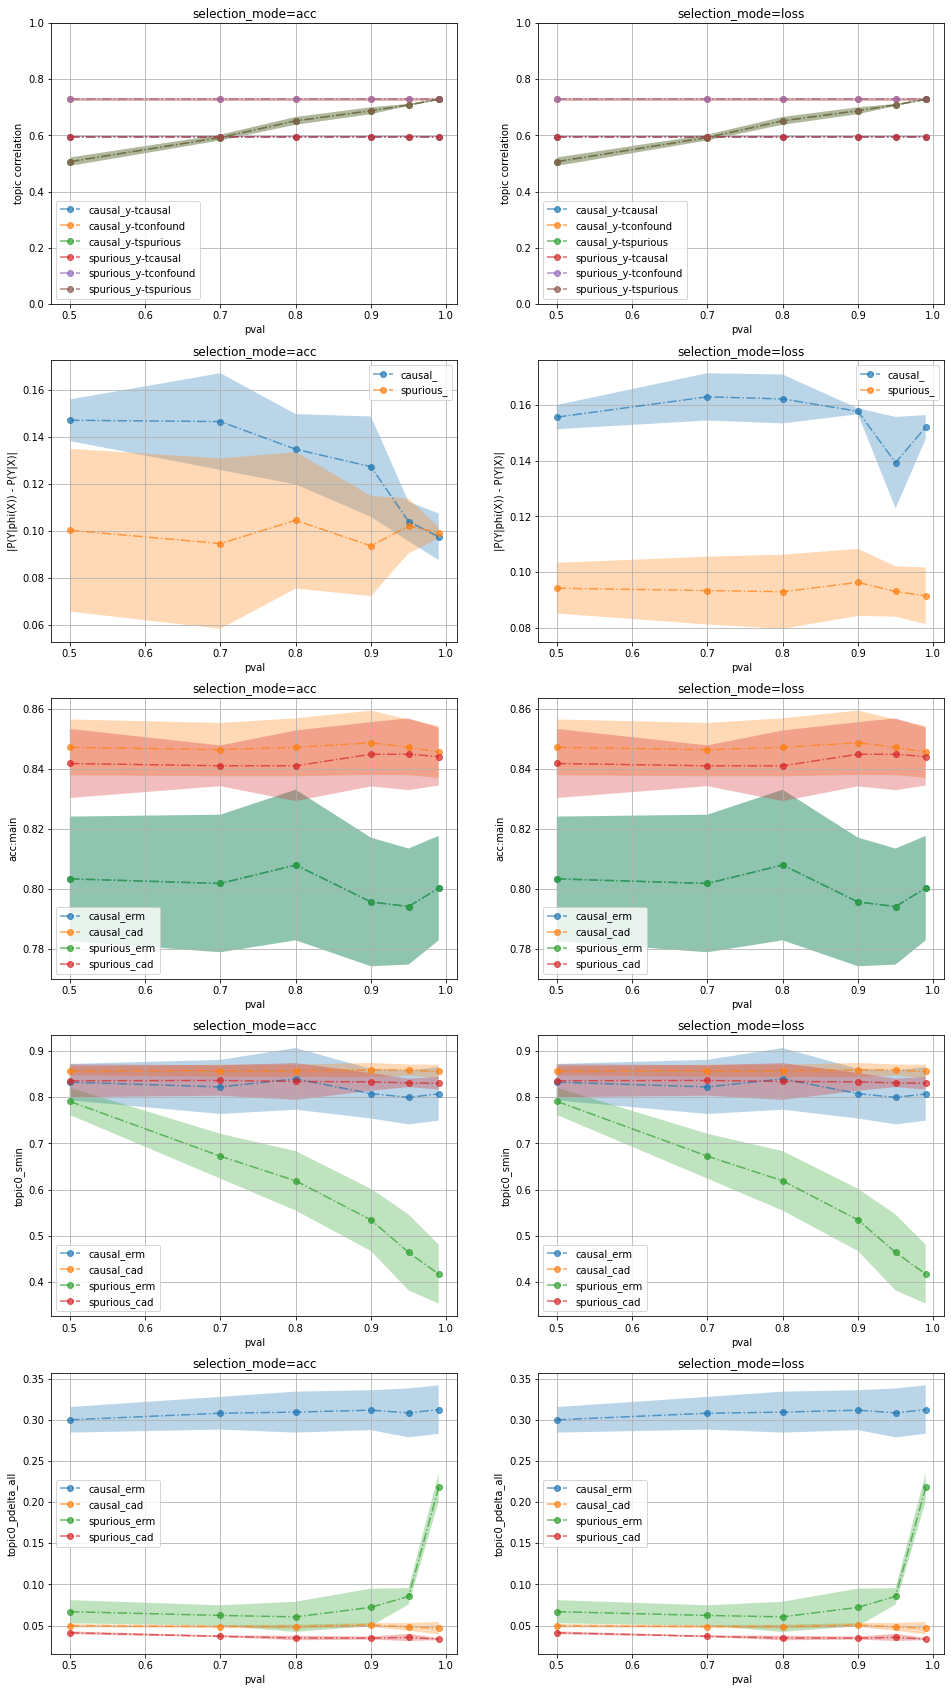

Bad pipe message: %s [b"\x83\xce\x97\xd9\x07;Q\xa4\xb1\x94sh^b\xafB\xa6\xb4 \x1f\xe8'\x17\xa9!*\xb2\xb5\x92\x15Qs\x9fj\x1bsI\xe3\x8fljA(\x80X\x04;\xdb\x0b\xa6\xb2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04"]
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 !\x84>\x1f\x80\x90\\\xbe\xa0a\xb1\x17\xb7\x141d[;\x10\xa2\x1f\xd3']
Bad pipe message: %s [b'\xb2\x1c\xe4m\x99\xe9\xf0K(n\xfc\xc8P\xc5zU\x7f\x03 \x00\x85\xf7K\xb3\xbfLo\xd5~\xe4o\x84\x9a>\xdb\xea1\xa6\xef\x87\x9b^\xde\xa6W*x\x8b\xc6\xde\xde\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x

Bad pipe message: %s [b"\x81\x9c\x8f \xe1qb\xf0?\xf9\xebp\x0e\x1b \x94\xe9\xad \tB\xb6:Aq\x02\xdb2\xd9s\xa5'\xd3\xd5\x98\xf5\xd0&\x95\x8aco#\x1e\x97\xa7\x90\xa1\xec\xd5x\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18"]
Bad pipe message: %s [b"\xf5\x1a\x06pQ\xa5\x07\x9f\x91U\x84l`\x97\xee\xa9IY\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00"]
Bad pipe message: %s [b'\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\

Bad pipe message: %s [b'G_R\xb9\xa5\x0c#\x98\x8a\xe9\xd6\x87\x8d\x00\xd5+\x11\xab \xa8\x14\xb8\xaa:\xfft']
Bad pipe message: %s [b"\xd6\x853\xee\x85E\xe3\xc8)b\xc9\xd8S@5\x03\xd0\xcf\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x02\x03\x03\x01\x02\x01\x03", b'\x02']
Bad pipe message: %s [b'\x05\x02\x06']
Ba

Bad pipe message: %s [b'\x1f\\\x08\\\x16A\x1d\xfcN\x13L\xf0T\xe80\x05\xd9< \xb2\xbd\xb1)\x9d\x95-\xa9\xaf\x1eS\x9d\x95\x87wX;\xb8W\x81\xbe\x0eZE\x82YP\xad"k\xe2\x99']
Bad pipe message: %s [b"B\xf6\xdds&\x08\xf7\xdb\x18\xd9yi,g\x1bPNm\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x02\x03\x03\x01\x02", b'', b'

In [159]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name ="spurious"
topic_name_list = ["causal","spurious"]
sample=1000
noise=0.1
mvsel_mode_list=["acc","loss"] #acc,loss
dcf=0.0 #0.0,0.5,1.0


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+2,2)


for topic_name in topic_name_list:
    for midx,mvsel_mode in enumerate(mvsel_mode_list):
        plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                          run_list=run_list,
                                          pval_list=pval_list,
                                          main_enum=main_enum,
                                          plot_item_list = plot_item_list,
                                          fname_pattern = fname_pattern.format(
                                                                            "{1}",
                                                                            topic_name,
                                                                            sample,
                                                                            noise,
                                                                            "{0}",
                                                                            dcf,
                                                                            mvsel_mode,
                                          ),
                                          title="selection_mode={}".format(mvsel_mode),
                                          label_prefix=topic_name+"_",
        )
plt.show()

# CivilComments dataset

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum(0).topic(race).sample(5000).noise(0.0).pval(0.5).mvsel(acc)/probe_metric_list_erm.json'

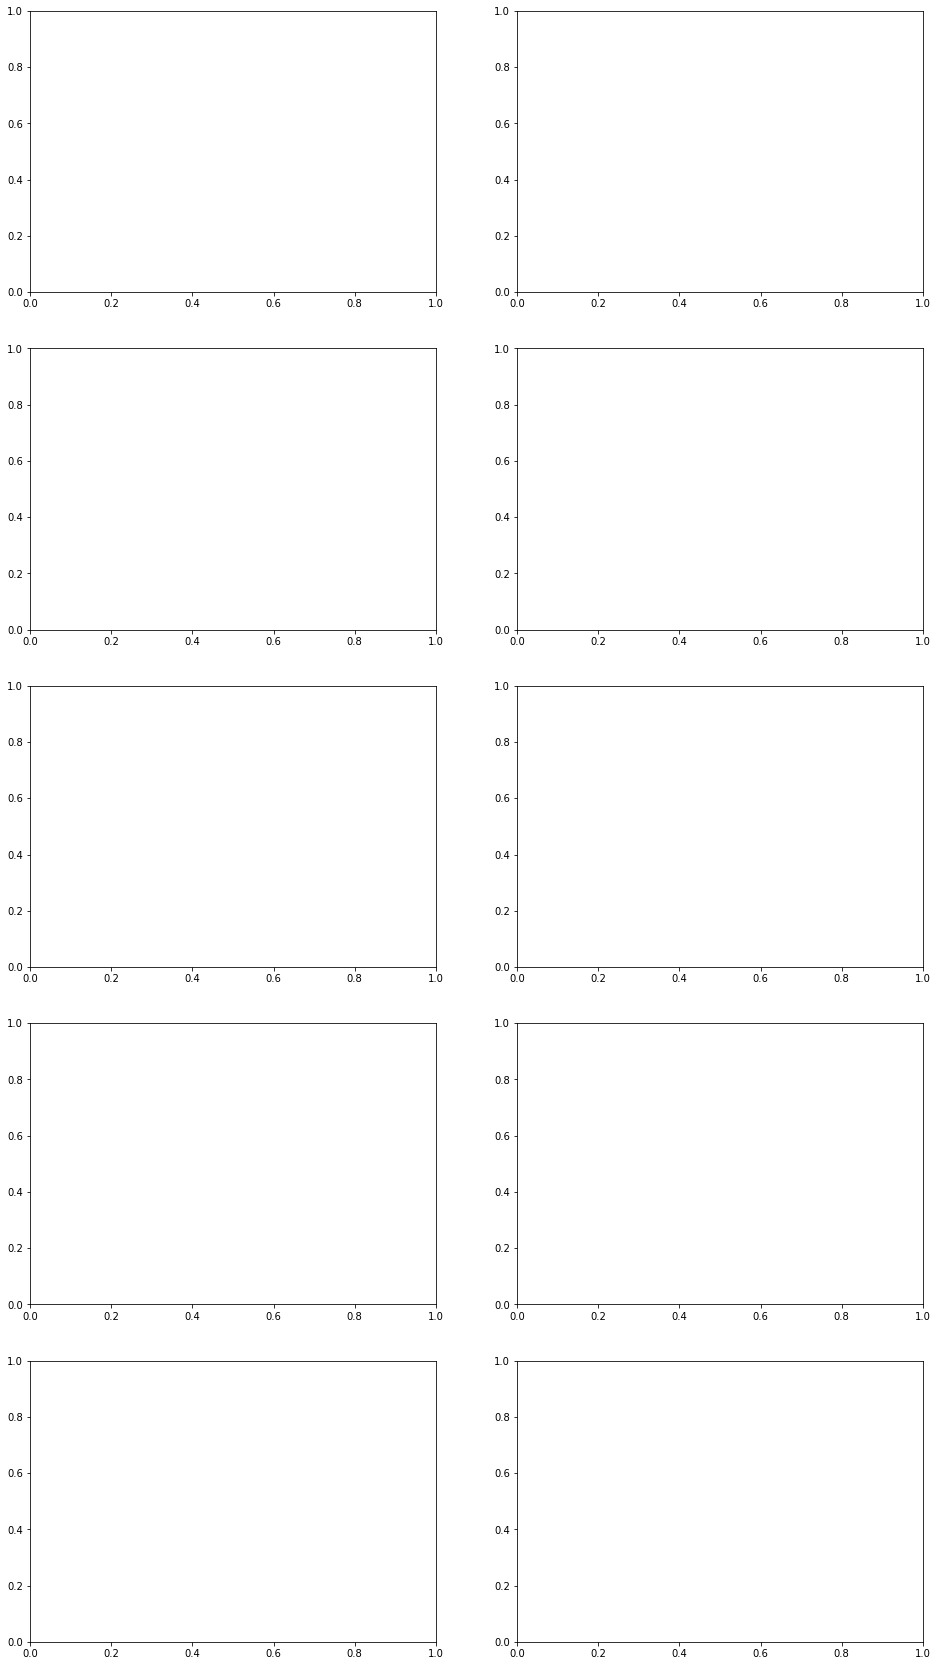

In [122]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.99]

main_enum=20
topic_name ="race"
sample=5000
noise=0.0
mvsel_mode_list=["acc","loss"] #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+1,2)


for midx,mvsel_mode in enumerate(mvsel_mode_list):
    plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                      run_list=run_list,
                                      pval_list=pval_list,
                                      main_enum=main_enum,
                                      plot_item_list = plot_item_list,
                                      fname_pattern = fname_pattern.format(
                                                                        "{1}",
                                                                        topic_name,
                                                                        sample,
                                                                        noise,
                                                                        "{0}",
                                                                        mvsel_mode,
                                      ),
                                      title="selection_mode={}".format(mvsel_mode),
    )
plt.show()

# AAE dataset

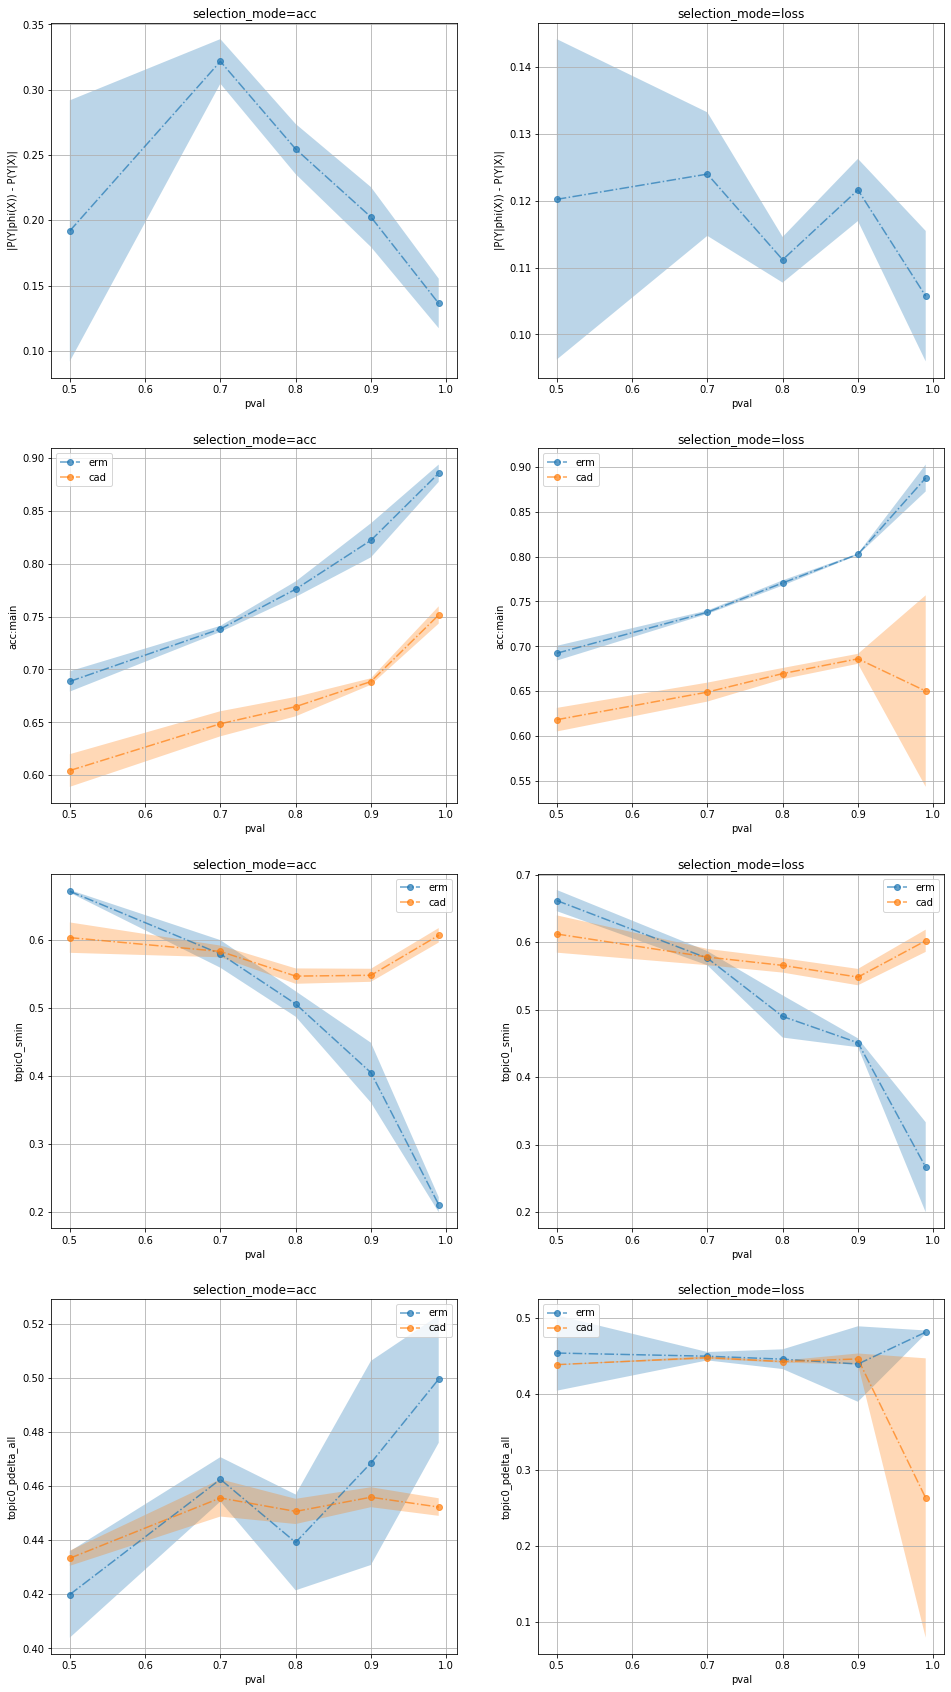

In [133]:
run_list=[1,2,]
pval_list=[0.5,0.7,0.8,0.9,0.99]

main_enum=20
topic_name ="race"
sample=10000
noise=0.0
mvsel_mode_list=["acc","loss"] #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+1,2)


for midx,mvsel_mode in enumerate(mvsel_mode_list):
    plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                      run_list=run_list,
                                      pval_list=pval_list,
                                      main_enum=main_enum,
                                      plot_item_list = plot_item_list,
                                      fname_pattern = fname_pattern.format(
                                                                        "{1}",
                                                                        topic_name,
                                                                        sample,
                                                                        noise,
                                                                        "{0}",
                                                                        mvsel_mode,
                                      ),
                                      title="selection_mode={}".format(mvsel_mode),
    )
plt.show()